### Characterising pixel response of BFS-U3-200S6M Sensor 📸

We want to model the non-linear response per pixel to incoming photons (of various ${\lambda}$ and across intensities).

There are multiple sources of noise that vary with wavelength (e.g. flicker or 1/f noise) and incoming intensity (e.g. shot noise) - 
to simplify analysis we will just fit a curve to each of these pixel responses outlined by:
https://www1.cs.columbia.edu/CAVE/publications/pdfs/Grossberg_PAMI04.pdf 

Lets try a gamma curve (bunch of lit refs that follow):
${f(E) = \alpha + \beta E^\gamma}$

Useful when performing phase retrieval (can only retrieve as good as your model represents)
(probably over-kill but this is an interesting task regardless)

Using 635nm laser source 🔴

In [19]:
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from scipy.interpolate import PchipInterpolator


### BFS Detector Info
CCD (Charge Coupled Device) sensors can be descirbed by a single value for readout noise because all charge is transported across the chip and read at a single corner of the array.

CMOS (Complementrary Metal-Oxide Semiconductor) sensors however have individual amplifier circuits per pixel, with each pixel/photosite read individually - so need per pixel read out noise to descibe these. **The BFS is a CMOS** detector

Shutters closed/0s exposure will give you readout noise

### Load and Process Raw frames
**NOTE**: running this once is fine. Will take quite some time (~7hr on toliman lab PC). Reading directly from Morgana2 drive.

Lets do average at each pixel and use the SEM as the error

In [4]:
exit()
fname_to_get = "Z:\gpir9156/toliman/detector" # Reading from Morgana because there is just so much data (300GB worth...)
                                            # Ran this on toliman laptop because faster
                                            # to access Morgana on my Mac: "/Volumes/Morgana2/gpir9156/toliman/detector" 

fname_to_save = "data/toliman/detector/"
print("File path exists?: {}".format(os.path.exists(fname_to_get)))

# start with the luminance files for each exposure (80us and 500us)
count = 0 # for my sanity
for name in os.listdir(fname_to_get):
    dir_name = os.path.join(fname_to_get, name)
    if name.endswith(".npy") and name.startswith("luminance"):
        print("Count: {}".format(count))
        print(name)
        count += 1
        data = np.load(dir_name)
        mean = np.mean(data, axis=0)
        stdev = np.std(data, axis=0)
        n = data.shape[0]

        SEM = stdev/np.sqrt(n)

        if not name.startswith("luminance"):
            print("Wrong file format")
            break

        if "80us" in name:
            _idx = name[10:].find("_") 
            fname = fname_to_save + "80us_detector/luminance_" + name[10:10+_idx] 
            np.save(file=fname + "_mean.npy", arr = mean )
            np.save(file=fname + "_SEM.npy", arr = SEM )

        elif "500us" in name:
            _idx = name[10:].find("_") 
            fname = fname_to_save + "500us_detector/luminance_" + name[10:10+_idx] 
            np.save(file=fname + "_mean.npy", arr = mean )
            np.save(file=fname + "_SEM.npy", arr = SEM )

        else:
            print("Un-identified exposure in {}".format(name))

# shutters
# for some reason one batch is corrupted - excluding
exclude = ["shutters_80us_0gain_img_stack_batch_2.npy"]
shutters_80us_means, shutters_500us_means = [],[] #okay to avg/std these out at the end since n is same for all
shutters_80us_SEMS, shutters_500us_SEMS = [],[]
for name in os.listdir(fname_to_get):
    if name.endswith(".npy") and name.startswith("shutters") and name not in exclude:
        dir_name = os.path.join(fname_to_get, name)
        print("Count: {}".format(count))
        count +=1
        print(name)
        data = np.load(dir_name, allow_pickle=False)

        mean = np.mean(data, axis=0)
        stdev = np.std(data, axis=0)
    
        if "80us" in name:
            shutters_80us_means.append(mean)
            shutters_80us_SEMS.append(stdev)
        elif "500us" in name:
            shutters_500us_means.append(mean)
            shutters_500us_SEMS.append(stdev)
        else:
            print("Un-identified exposure in {}".format(name))

print(np.asarray(shutters_500us_means).shape)
print(np.asarray(shutters_80us_means).shape)
mean_shutters_80us = np.mean(np.asarray(shutters_80us_means), axis=0)
mean_shutters_500us = np.mean(np.asarray(shutters_500us_means), axis=0)
SEM_shutters_80us = np.std(np.asarray(shutters_80us_SEMS) , axis=0)/np.sqrt(600) #200 frames per batch
SEM_shutters_500us = np.std(np.asarray(shutters_500us_SEMS), axis=0)/np.sqrt(600)

fname = fname_to_save + "80us_detector/shutters"
np.save(file=fname + "_mean.npy", arr = mean_shutters_80us )
np.save(file=fname + "_SEM.npy", arr = SEM_shutters_80us )

fname = fname_to_save + "500us_detector/shutters"
np.save(file=fname + "_mean.npy", arr = mean_shutters_500us )
np.save(file=fname + "_SEM.npy", arr = SEM_shutters_500us )


File path exists?: True
/Volumes/Morgana2/gpir9156/toliman/detector/luminance_4000_500us_0gain_img_stack_batch_0.npy


#### Create Nice Dataframe 

Again - can run this just once to save files. Takes ~20min to run on my Mac

In [20]:
exit()
fname_to_get = ["/Volumes/Morgana2/gpir9156/toliman/detector/80us_detector/","/Volumes/Morgana2/gpir9156/toliman/detector/500us_detector/"]
fname_to_save = ["data/80us_detector/","data/500us_detector/"]

for i, fname in enumerate(fname_to_get):
    print("File path exists?: {}".format(os.path.exists(fname)))

    sorted_files = sorted(os.listdir(fname))
    n_files = len(sorted_files)
    assert n_files % 2 == 0, "Odd number of files in directory. Each mean file should have a corresponding SEM file"

    luminances = []
    SEMs = []
    means = []
    for file in sorted_files:
        filename = os.fsdecode(file)
        print(filename)
        if filename.startswith("luminance"):
            _idx = filename[10:].find("_") 
            luminances.append(int(filename[10:10+_idx]))

            if filename.endswith("SEM.npy"):
                SEMs.append(np.load(fname+filename))
            else:
                means.append(np.load(fname+filename))
        elif filename.startswith("shutters"):
            luminances.append(0)
            if filename.endswith("SEM.npy"):
                SEMs.append(np.load(fname+filename))
            else:
                means.append(np.load(fname+filename))
        else:
            ValueError("Un-identified file format.")

    SEMs = np.asarray(SEMs)
    means = np.asarray(means)

    indexes = np.unique(luminances, return_index=True)[1]
    luminances = np.asarray([luminances[index] for index in sorted(indexes)])

    print("Luminances shape: {}\n SEMs shape: {}\n Means shape: {}".format(luminances.shape, SEMs.shape, means.shape))
    np.save(file=fname_to_save[i] + "luminances.npy", arr=luminances)
    np.save(file=fname_to_save[i] + "means.npy", arr=means)
    np.save(file=fname_to_save[i] + "SEMs.npy", arr=SEMs)




File path exists?: True
luminance_10000_SEM.npy
luminance_10000_mean.npy
luminance_1000_SEM.npy
luminance_1000_mean.npy
luminance_20000_SEM.npy
luminance_20000_mean.npy
luminance_2000_SEM.npy
luminance_2000_mean.npy
luminance_25000_SEM.npy
luminance_25000_mean.npy
luminance_30000_SEM.npy
luminance_30000_mean.npy
luminance_3000_SEM.npy
luminance_3000_mean.npy
luminance_35000_SEM.npy
luminance_35000_mean.npy
luminance_40000_SEM.npy
luminance_40000_mean.npy
luminance_45000_SEM.npy
luminance_45000_mean.npy
luminance_50000_SEM.npy
luminance_50000_mean.npy
luminance_5000_SEM.npy
luminance_5000_mean.npy
luminance_500_SEM.npy
luminance_500_mean.npy
luminance_52500_SEM.npy
luminance_52500_mean.npy
luminance_6000_SEM.npy
luminance_6000_mean.npy
luminance_7000_SEM.npy
luminance_7000_mean.npy
luminance_8000_SEM.npy
luminance_8000_mean.npy
luminance_9000_SEM.npy
luminance_9000_mean.npy
shutters_SEM.npy
shutters_mean.npy
Luminances shape: (19,)
 SEMs shape: (19, 3648, 5472)
 Means shape: (19, 3648, 

#### Display Reduced Data 👁️

Luminance within 1% 

Detector is (3648, 5472), 2:3, so not sure best way to display this, start with 4x6 plot first? Think PC might break tbh

Break up detector into areas and overlap curves

#### 80us Exposure:

In [26]:
height, width = 3648, 5472
n_row =4
n_col = 6

y_step, x_step = height/n_row, width/n_col 

means = np.load("data/80us_detector/means.npy")
SEMs = np.load("data/80us_detector/SEMs.npy")   
luminances = np.load("data/80us_detector/luminances.npy")


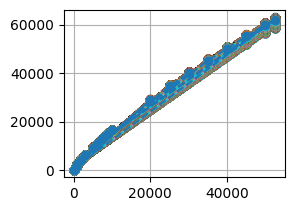

In [5]:
# This is way too intensive to plot all curves
exit()
plt.figure(figsize=(20, 10))
for subplot_row in range(n_row):
    for subplot_col in range(n_col):
        subplot = subplot_row*n_col + subplot_col + 1
        plt.subplot(n_row, n_col, subplot)

        y_min, y_max = int(subplot_row*y_step), int(y_step*(subplot_row+1)-1)
        x_min, x_max = int(subplot_col*x_step), int(x_step*(subplot_col+1)-1)
        sub_arr = means[:, y_min:y_max, y_min:y_max]

        for i in range(sub_arr.shape[-1]):
            for j in range(sub_arr.shape[-2]):
                plt.plot(luminances, sub_arr[:, i, j], '--o')

        plt.grid()
        break

    break
        


#     plt.title("Luminance: {}".format(luminances[subplot]))
#     plt.axis('off')

# print(means[0].shape)


#### Fitting Time 🧥

Single pixel to test.

R^2: 0.99994


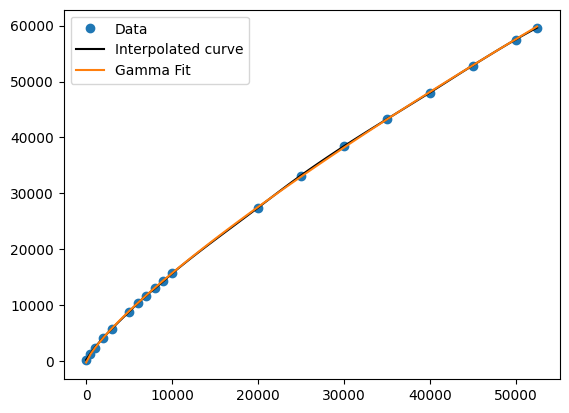

In [40]:
# try fitting one frame
# plt.errorbar(luminances, means[:,0,0], yerr=SEMs[:,0,0], marker = 'o', linestyle='') #errors are so small you don't see the error bars (idk if this is a machine error thing)
# print(SEMs[:,0,0])

idx_sort = np.argsort(luminances)
sorted_luminances = luminances[idx_sort]
y = means[:,0,0]
y = y[idx_sort]


plt.plot(sorted_luminances, y, marker = 'o', linestyle='', label="Data")
interp_fn = PchipInterpolator(x=sorted_luminances, y=y)
x_interp = np.linspace(sorted_luminances[0], sorted_luminances[-1], 100)
y_interp = interp_fn(x_interp)
plt.plot(x_interp, y_interp, 'k',label="Interpolated curve")

# Fit
def gamma_curve(x, alpha, beta, gamma):

    return alpha + beta*(x**gamma)

p0 = np.array([0,0,1.1])
coeffs, covar = curve_fit(gamma_curve, x_interp, y_interp, p0=p0)
fit_vals = gamma_curve(x_interp, *coeffs)
plt.plot(x_interp, fit_vals, label="Gamma Fit")

plt.legend()
r2 = 1 - (np.sum((y_interp-fit_vals)**2))/(np.sum( (y_interp-np.mean(y_interp))**2 ))

print("R^2: {:.5f}".format(r2))

#numpy.power will let you raise by individual powers!

In [37]:
# Lets do it all 

# Sort for interpolation
idx_sort = np.argsort(luminances)
sorted_luminances = luminances[idx_sort]
x_interp = np.linspace(sorted_luminances[0], sorted_luminances[-1], 100)

# Fit function
def gamma_curve(x, alpha, beta, gamma):

    return alpha + beta*(x**gamma)

# fit init params
p0 = np.array([0,0,1.1])

ALPHA = np.zeros(height,width)
BETA = np.zeros(height,width)
GAMMA = np.zeros(height,width)
RSQR = np.zeros(height,width)
for row_idx in range(height):
    for col_idx in range(width):
        y = means[:,row_idx,col_idx]
        y = y[idx_sort]
        interp_fn = PchipInterpolator(x=sorted_luminances, y=y)
        y_interp = interp_fn(x_interp)

        coeffs, covar = curve_fit(gamma_curve, x_interp, y_interp, p0=p0)
        fit_vals = gamma_curve(x_interp, *coeffs)

        r2 = 1 - (np.sum((y_interp-fit_vals)**2))/(np.sum( (y_interp-np.mean(y_interp))**2 ))

        if r2 < 0.9:
            print("({},{}) with r2 {}".format(row_idx,col_idx,r2))
            break

        ALPHA[row_idx,col_idx] = coeffs[0]
        BETA[row_idx,col_idx] = coeffs[1]
        GAMMA[row_idx,col_idx] = coeffs[2]
        RSQR[row_idx,col_idx] = r2


(19, 3648, 5472)


Take intensity sweeps at two different exposures 80ms (spider data and Jewel too) and 500ms gain 0 always

100 frames each 

0 cd/m^2 is me putting on shutters

cd/m^2 range: 
cd/m^2 uncertainty: 

Camera left to warm up (running) for 10min

Bandpass filter of 530-640nm for characterisation

In [ ]:
# Fave optimiser to fit curve?


#### Matrix representation

In [ ]:
# For a sweep of input, uniform intensities - measure the difference between pixels (flat field)